# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [1]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [2]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

---
---

In [11]:
!pip install torchsummary

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import random
from typing import List, Tuple
from torch import Tensor
from pathlib import Path
from torchvision import transforms as T, datasets
from PIL import Image
from torch.utils.data import random_split, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import os
import json
from torchsummary import summary
import pandas as pd
import copy
from torchvision.models import resnet18, ResNet18_Weights


SEED = 42

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

def fix_random(seed: int) -> None:
    """
        Fix all the possible sources of randomness.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Device: cuda


## Data exploration

### Train and validation distributions

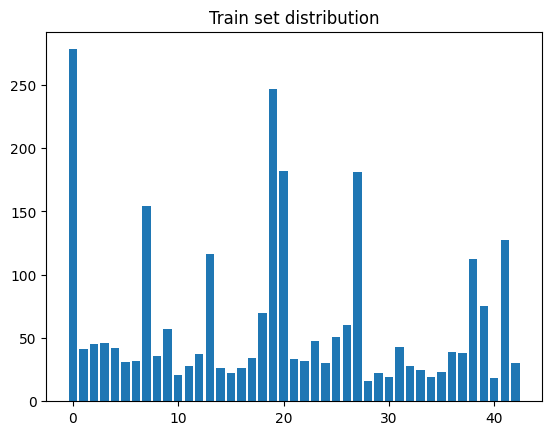

In [6]:
train_data = GroceryStoreDataset(split="train")
unique_train_classes, per_train_class_count = np.unique(train_data.labels, return_counts=True)
plt.title("Train set distribution")
plt.bar(unique_train_classes, per_train_class_count)
plt.show()

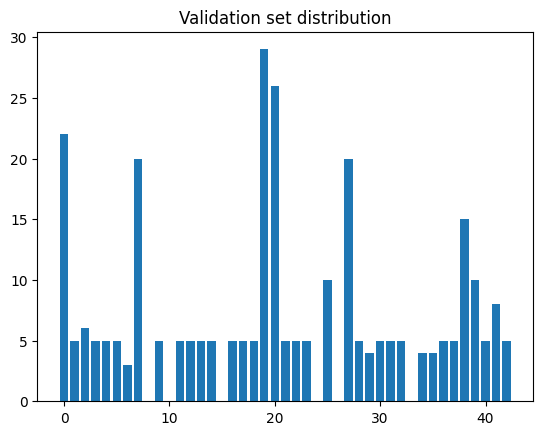

In [7]:
val_data = GroceryStoreDataset(split="val")
unique_val_classes, per_val_class_count = np.unique(val_data.labels, return_counts=True)
plt.title("Validation set distribution")
plt.bar(unique_val_classes, per_val_class_count)
plt.show()

## Data preprocessing

### Dataset loading

In [4]:
NUM_CLASSES = 43
INPUT_WIDTH = 348
INPUT_HEIGHT = 348

tsfms = T.Compose([
    T.ToTensor(),
    T.CenterCrop((INPUT_HEIGHT, INPUT_WIDTH)) # Some images are not the same size
])

train_dset = GroceryStoreDataset(split="train", transform=tsfms)
test_dset = GroceryStoreDataset(split="test", transform=tsfms)
val_dset = GroceryStoreDataset(split="val", transform=tsfms)

### Augmentation

In [ ]:
# Define the data augmentation transformations
USE_DATA_AUGMENTATION = False
AUGMENTATION_FACTOR = 2

augmentation_transforms = [T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop((INPUT_HEIGHT, INPUT_WIDTH), scale=(0.8, 1.0)),
    T.ToTensor(),
    T.CenterCrop((INPUT_HEIGHT, INPUT_WIDTH)) # Some images are not the same size
]), T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop((INPUT_HEIGHT, INPUT_WIDTH), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor(),
    T.CenterCrop((INPUT_HEIGHT, INPUT_WIDTH)) # Some images are not the same size
])]

# Check if thge file 'train_dset.pt' exists
if Path('train_dset.pt').exists():
    train_dset = torch.load('train_dset.pt')
else:
    # Concatenate the original and augmented training datasets
    if USE_DATA_AUGMENTATION:
        fix_random(SEED)
        print(f'Train dataset size before augmentation: {len(train_dset)}')
        for i in range(AUGMENTATION_FACTOR):
            for j in range(len(augmentation_transforms)):
                augmented_train_dset = GroceryStoreDataset(split="train", transform=augmentation_transforms[j])
                train_dset = ConcatDataset([train_dset, augmented_train_dset])
        print(f'Train dataset size after augmentation: {len(train_dset)}')
        # Dump the whole dataset for later use in order to avoid recomputing the augmentations
        torch.save(train_dset, 'train_dset.pt')

### Rebalancing

In [ ]:
REBALANCE_DATASET = False

class GroceryStoreDatasetFilteredByLabel(GroceryStoreDataset):
    def __init__(self, split: str, transform=None, label=None) -> None:
        super().__init__(split, transform)

        self.paths = [ p for i, p in enumerate(self.paths) if self.labels[i] == label ]
        self.labels = [label] * len(self.paths)

In [ ]:
if REBALANCE_DATASET:
    fix_random(SEED)
    balanced_train_dset = GroceryStoreDataset(split="train", transform=tsfms)
    balanced_count = [ balanced_train_dset.labels.count(i) for i in range(NUM_CLASSES) ]
    biggest_class_size = np.max(balanced_count)

    for i in range(NUM_CLASSES):
        size_label_i = train_dset.labels.count(i)
        increase_factor = round(biggest_class_size / size_label_i)

        for j in range(increase_factor-1):
            augmented_i = GroceryStoreDatasetFilteredByLabel(split="train", transform=augmentation_transforms[j % 2], label=i)
            balanced_train_dset = ConcatDataset([balanced_train_dset, augmented_i])
            balanced_count[i] += len(augmented_i)

    train_dset = balanced_train_dset

    plt.title("Rebalanced train set distribution")
    plt.bar(range(NUM_CLASSES), balanced_count)
    plt.show()

## Utility functions

### Parameters count

In [5]:
def getTotalParameters(ModelClass):
    model = ModelClass(NUM_CLASSES)
    total_params = 0

    for _, parameter in model.named_parameters():
        total_params += parameter.numel()

    return total_params

In [6]:
def print_model_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param_count = parameter.numel()
        total_params += param_count

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param_count = parameter.numel()
        print(f"Layer: {name:<30} | Parameters: {param_count:<8} ({param_count/total_params*100:.2f}%)")
        
    print(f"Total Trainable Parameters: {total_params}")

### Evaluation on dataset split

In [7]:
def evaluate(model, dataloader, device):
    corrects = 0
    total = 0
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        for image, labels in dataloader:
            image, labels = image.to(device), labels.to(device)
            pred_logits = model(image)
            _, preds = torch.max(pred_logits, 1)
            corrects += (preds == labels).sum().item()
            total += labels.shape[0]

    return corrects / total

### Training loop

In [8]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    train_dl,
    val_dl,
    device,
    n_epochs,
    early_stop_val_acc = 0.6,
    checkpoint_path = None,
    logging_path = None
):
    if checkpoint_path is not None: os.makedirs(checkpoint_path, exist_ok=True)
    if logging_path is not None: os.makedirs(logging_path, exist_ok=True)

    history = []
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    for epoch in (pbar := tqdm(range(n_epochs))):
        batch_train_accuracies = []
        batch_train_losses = []
        batch_train_times = []
        val_accuracy = 0
        val_loss = 0
        curr_lr = scheduler.get_last_lr()[-1] if scheduler is not None else optimizer.param_groups[-1]['lr']

        # Train
        model.train()
        for i, (images, labels) in enumerate(train_dl):
            pbar.set_description(f"Epoch {epoch+1} ({i+1}/{len(train_dl)}) [lr: {curr_lr:.3e}]")
            if device == "cuda":
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
            images, labels = images.to(device), labels.to(device)

            if device == "cuda": start_time.record()
            optimizer.zero_grad()
            pred_logits = model(images)
            loss = loss_fn(pred_logits, labels)
            loss.backward()
            optimizer.step()
            if device == "cuda": end_time.record()

            _, preds = torch.max(pred_logits, 1)
            batch_train_accuracies.append((preds == labels).sum().item() / labels.size(0))
            batch_train_losses.append(loss.item())
            if device == "cuda":
                torch.cuda.synchronize()
                batch_train_times.append(start_time.elapsed_time(end_time))
        if scheduler is not None:
            scheduler.step()

        # Validation
        model.eval()
        val_accuracy_per_label_count = np.zeros((NUM_CLASSES, 2))
        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                preds_logits = model(images)
                _, pred = torch.max(preds_logits, 1)
                val_accuracy += (pred == labels).sum().item()
                for class_idx in range(NUM_CLASSES):
                    val_accuracy_per_label_count[class_idx,0] += np.logical_and((pred == labels).cpu().numpy(), (labels == class_idx).cpu().numpy()).sum()
                    val_accuracy_per_label_count[class_idx,1] += (labels == class_idx).sum().item()
                
                val_loss += loss_fn(preds_logits, labels).item() * labels.shape[0]
                
        val_accuracy = val_accuracy / len(val_dl.dataset)
        val_accuracy_per_label_count[val_accuracy_per_label_count[:,1] == 0, 1] = np.inf
        val_accuracy_per_label = val_accuracy_per_label_count[:,0] / val_accuracy_per_label_count[:,1]
        val_loss = val_loss / len(val_dl.dataset)

        print(
            f"Epoch {epoch + 1:<3} [lr: {curr_lr:.3e}] | "
            f"train_acc: {np.mean(batch_train_accuracies):.4f} "
            f"train_loss: {np.mean(batch_train_losses):.4f} "
            f"val_acc: {val_accuracy:.4f} "
            f"val_loss: {val_loss:.4f}",
        )

        # Checkpoint
        if checkpoint_path is not None:
            torch.save({
                "state_dict": model.state_dict(),
                "architecture": str(model)
            }, os.path.join(checkpoint_path, f"epoch{epoch+1}.ckp.pt"))

        # Logging
        epoch_logs = {
            "epoch": epoch + 1,
            "batch_train_accuracies": batch_train_accuracies,
            "batch_train_losses": batch_train_losses,
            "batch_train_times": batch_train_times,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss,
            "val_accuracy_per_label": val_accuracy_per_label.tolist()
        }
        if logging_path is not None:
            with open(os.path.join(logging_path, f"epoch{epoch+1}.log.json"), "w") as f:
                json.dump(epoch_logs, f, indent=3)
        history.append(epoch_logs)

        if (early_stop_val_acc is not None) and (val_accuracy >= early_stop_val_acc):
            break

    return history


In [9]:
def runForMultipleSeeds(ModelClass, num_runs, Loss, loss_args, Optimizer, optimizer_args, Scheduler, scheduler_args, batch_size, epochs, early_stop, device, random_seed, ckp_label=""):
    rng = np.random.default_rng(random_seed)
    runs_history = [None] * num_runs
    
    for i in range(num_runs):
        curr_seed = int(rng.integers(0, 2**32-1))
        fix_random(curr_seed)
        print(f"Running with seed: {curr_seed}")
        
        model = ModelClass(NUM_CLASSES).to(device)
        loss = Loss(**loss_args)
        optimizer = Optimizer(model.parameters(), **optimizer_args)
        scheduler = None
        if Scheduler is not None:
            scheduler = Scheduler(optimizer, **scheduler_args)
        train_dl = DataLoader(train_dset, batch_size, shuffle=True)

        runs_history[i] = train(
            model = model,
            loss_fn = loss,
            optimizer = optimizer,
            scheduler = scheduler,
            train_dl = train_dl,
            val_dl = DataLoader(val_dset, 256),
            device = device,
            n_epochs = epochs,
            early_stop_val_acc = early_stop,
            checkpoint_path = f"./checkpoints{i}_{ModelClass.__name__}_{ckp_label}",
            logging_path = f"./logs{i}_{ModelClass.__name__}_{ckp_label}"
        )
        
    return runs_history

### Plots

In [10]:
def plotLossAndAccuracy(histories, title):
    colors = "rgb"

    plt.figure(figsize=(16, 4))
    plt.suptitle(title)
    for i in range(len(histories)):
        logs = histories[i]
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(range(logs[-1]["epoch"]), [np.mean(logs[i]["batch_train_losses"]) for i in range(len(logs))], label=f"Train run {i}", color=colors[i%len(colors)])
        plt.plot(range(logs[-1]["epoch"]), [logs[i]["val_loss"] for i in range(len(logs))], "--", label=f"Val run {i}", color=colors[i%len(colors)])
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(range(logs[-1]["epoch"]), [np.mean(logs[i]["batch_train_accuracies"]) for i in range(len(logs))], label=f"Train run {i}", color=colors[i%len(colors)])
        plt.plot(range(logs[-1]["epoch"]), [logs[i]["val_accuracy"] for i in range(len(logs))], "--", label=f"Val run {i}", color=colors[i%len(colors)])
        plt.legend()
    plt.show()
    

def plotValPredictionDistribution(histories, title):
    colors = "rgb"
    
    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Validation set correct predictions (%) and real distribution - {title}")
    plt.subplot(2, 1, 1)
    for i in range(len(histories)):
        best_val_acc_idx = np.argmax(histories[i][j]["val_accuracy_per_label"] for j in range(len(histories[i])))
        acc_per_label = histories[i][best_val_acc_idx]["val_accuracy_per_label"]
        plt.bar(range(len(acc_per_label)), acc_per_label, facecolor=colors[i%len(colors)], alpha=0.3, edgecolor="black", linewidth=2, label=f"run {i}")
    plt.legend()
    plt.subplot(2, 1, 2)
    unique_val_classes, per_val_class_count = np.unique(val_dset.labels, return_counts=True)
    plt.bar(unique_val_classes, per_val_class_count)
    plt.show()

### Reporting

In [11]:
def analyzeRunsHistory(ModelClass, label, histories):
    runs_val_acc = []

    for num_run in range(len(histories)):
        best_val_acc = np.max([ histories[num_run][i]["val_accuracy"] for i in range(len(histories[num_run])) ])
        runs_val_acc.append(best_val_acc)

    return {
        "model": ModelClass.__name__,
        "label": label,
        "parameters": getTotalParameters(ModelClass),
        "avg_val_accuracy": np.mean(runs_val_acc),
        "min_val_accuracy": np.min(runs_val_acc),
        "max_val_accuracy": np.max(runs_val_acc),
        "num_runs": len(histories)
    }

In [58]:
def loadLogs(dir_path):
    run_dirs = [ f.path for f in os.scandir(dir_path) if f.is_dir() ]
    histories = [[] for _ in range(len(run_dirs))]

    for i, run_dir in enumerate(run_dirs):
        history_json_paths = next(os.walk(run_dir))[2]

        for json_path in history_json_paths:
            with open(os.path.join(run_dir, json_path), "r") as f:
                history_json = json.load(f)
                histories[i].append(history_json)
    for i in range(len(histories)):
        histories[i].sort(key=lambda x: x["epoch"])

    return histories

## Part 1
---

### Basic Model

Each Convolutional block in the network has the following structure:
1. 2D Convolution
2. SiLU Activation Function
3. Max Pooling
4. Batch Normalization
5. Dropout

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, kernel_size, in_channels, out_channels, activation, use_batch_norm=True, use_skip=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation()
        self.use_skip = use_skip

        block_components = [
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = kernel_size,
                stride = 2,
                padding = "valid"
            ),
            nn.BatchNorm2d(out_channels) if use_batch_norm else None,
            self.activation,
            nn.Conv2d(
                in_channels = out_channels,
                out_channels = out_channels,
                kernel_size = kernel_size,
                stride = 1,
                padding = "same"
            ),
            nn.BatchNorm2d(out_channels) if use_batch_norm else None,
            # self.activation,
            # nn.Conv2d(
            #     in_channels = out_channels,
            #     out_channels = out_channels,
            #     kernel_size = kernel_size,
            #     stride = 1,
            #     padding = "same"
            # ),
            # nn.BatchNorm2d(out_channels),
        ]
        self.block = nn.Sequential(*[ b for b in block_components if b is not None ])
        
        if use_skip:
            self.skip_block = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding="valid")

    def forward(self, x):
        out = self.block(x)
        # Residual connection
        if self.use_skip:
            residual = self.skip_block(x)
            out = out + residual
        return self.activation(out)


### First Model

In [14]:
class GroceryModelModular(nn.Module):
    def __init__(self, stem_block, conv_block, linear_block):
        super().__init__()
        self.stem_block = nn.Sequential(*stem_block)
        self.conv_block = nn.Sequential(*conv_block)
        self.linear_block = nn.Sequential(*linear_block)

    def forward(self, x):
        x = self.stem_block(x)
        x = self.conv_block(x)
        # Before flattening the tensor, to further reduce the parameters
        # we use adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear_block(x)
        return x

In [15]:
class GroceryModelFull(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [16]:
model = GroceryModelFull(NUM_CLASSES).to(device)
print_model_parameters(model)
print()
summary(model, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device.type)

Layer: stem_block.0.weight            | Parameters: 1800     (0.86%)
Layer: stem_block.0.bias              | Parameters: 24       (0.01%)
Layer: stem_block.1.weight            | Parameters: 24       (0.01%)
Layer: stem_block.1.bias              | Parameters: 24       (0.01%)
Layer: stem_block.3.weight            | Parameters: 19200    (9.16%)
Layer: stem_block.3.bias              | Parameters: 32       (0.02%)
Layer: stem_block.4.weight            | Parameters: 32       (0.02%)
Layer: stem_block.4.bias              | Parameters: 32       (0.02%)
Layer: conv_block.0.block.0.weight    | Parameters: 13824    (6.60%)
Layer: conv_block.0.block.0.bias      | Parameters: 48       (0.02%)
Layer: conv_block.0.block.1.weight    | Parameters: 48       (0.02%)
Layer: conv_block.0.block.1.bias      | Parameters: 48       (0.02%)
Layer: conv_block.0.block.3.weight    | Parameters: 20736    (9.90%)
Layer: conv_block.0.block.3.bias      | Parameters: 48       (0.02%)
Layer: conv_block.0.block.4.weight

In [ ]:
default_args = {
    "ModelClass": GroceryModelFull, 
    "num_runs": 3,
    "Loss": nn.CrossEntropyLoss, 
    "loss_args": {}, 
    "Optimizer": optim.Adam, 
    "optimizer_args": { "lr": 1e-4, "weight_decay": 0.1 }, 
    "Scheduler": None,
    "scheduler_args": {},
    # Scheduler = optim.lr_scheduler.LinearLR, 
    # scheduler_args = { "start_factor": 1, "end_factor": 1/8, "total_iters": 25 }, 
    "batch_size": 64, 
    "epochs": 50,
    "early_stop": None,
    "device": device,
    "random_seed": SEED
}

histories_full = runForMultipleSeeds(**default_args)

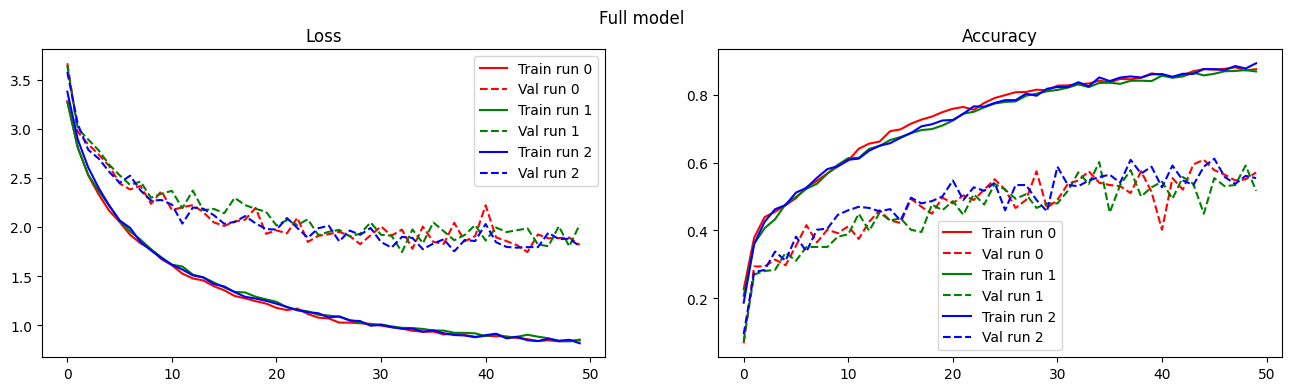

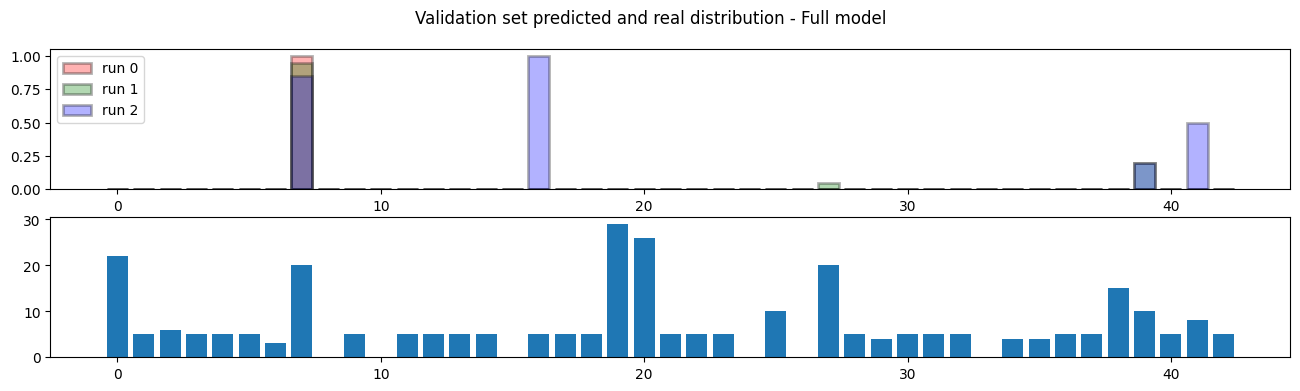

In [65]:
plotLossAndAccuracy(histories_full, "Full model")
plotValPredictionDistribution(histories_full, "Full model")

### Ablation study

In [17]:
class GroceryModelSmallStem(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [18]:
class GroceryModelNoStem(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=3, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [19]:
class GroceryModelSmallConvBlock(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(48, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [20]:
class GroceryModelSmaller(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(16),
                nn.SiLU(),
                nn.Conv2d(in_channels=16, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=24, out_channels=32, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(48, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [21]:
class GroceryModelSmallLinear(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 128),
                nn.BatchNorm1d(128),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(128, n_classes)
            ]
        )

In [22]:
class GroceryModelNoBatchNorm(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU, use_batch_norm=False),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU, use_batch_norm=False)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.SiLU(),
                nn.Dropout(p=0.1),
                nn.Linear(256, n_classes)
            ]
        )

In [23]:
class GroceryModelNoDropout(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Linear(256, n_classes)
            ]
        )

In [24]:
class GroceryModelNoSkip(GroceryModelModular):
    def __init__(self, n_classes):
        super().__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(24),
                nn.SiLU(),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding="valid"),
                nn.BatchNorm2d(32),
                nn.SiLU()
            ], 
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation=nn.SiLU, use_skip=False),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation=nn.SiLU, use_skip=False)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Linear(256, n_classes)
            ]
        )

In [ ]:
to_test_models = [
    GroceryModelSmallStem, 
    GroceryModelSmallConvBlock, 
    GroceryModelNoStem, 
    GroceryModelSmaller, 
    GroceryModelSmallLinear, 
    GroceryModelNoBatchNorm, 
    GroceryModelNoDropout,
    GroceryModelNoSkip
]

stats_arch_ablation = []

for Model in to_test_models:
    print(f"Running {Model.__name__}")

    args = copy.deepcopy(default_args)
    args["ModelClass"] = Model
    histories = runForMultipleSeeds(**args)
    
    stats_arch_ablation.append( analyzeRunsHistory(Model, "",  histories) )
    plotLossAndAccuracy(histories, Model.__name__)
    plotValPredictionDistribution(histories, Model.__name__)

In [ ]:
histories_hyper_study = []
stats_hyper_study = []

args = copy.deepcopy(default_args)
args["optimizer_args"] = { "lr": 1e-4 }
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="no_wd") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "no weight decay", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + no weight decay")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + no weight decay")

args = copy.deepcopy(default_args)
args["optimizer_args"] = { "lr": 5e-4, "weight_decay": 0.1 }
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="high_lr") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "higher LR", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + higher LR")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + higher LR")

args = copy.deepcopy(default_args)
args["batch_size"] = 32
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="small_bs") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "smaller batch size", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + smaller batch size")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + smaller batch size")

args = copy.deepcopy(default_args)
args["batch_size"] = 128
histories_hyper_study.append( runForMultipleSeeds(**args, ckp_label="large_bs") )
stats_hyper_study.append( analyzeRunsHistory(GroceryModelFull, "larger batch size", histories_hyper_study[-1]) )
plotLossAndAccuracy(histories_hyper_study[-1], "Full model + larger batch size")
plotValPredictionDistribution(histories_hyper_study[-1], "Full model + larger batch size")

#### Results

In [67]:
histories_full = loadLogs("./train-logs/GroceryModelFull")
histories_small_stem = loadLogs("./train-logs/GroceryModelSmallStem")
histories_small_conv_block = loadLogs("./train-logs/GroceryModelSmallConvBlock")
histories_no_stem = loadLogs("./train-logs/GroceryModelNoStem")
histories_smaller = loadLogs("./train-logs/GroceryModelSmaller")
histories_small_linear = loadLogs("./train-logs/GroceryModelSmallLinear")
histories_no_batch_norm = loadLogs("./train-logs/GroceryModelNoBatchNorm")
histories_no_dropout = loadLogs("./train-logs/GroceryModelNoDropout")
histories_no_skip = loadLogs("./train-logs/GroceryModelNoSkip")
histories_full_no_wd = loadLogs("./train-logs/GroceryModelFull_no_wd")
histories_full_high_lr = loadLogs("./train-logs/GroceryModelFull_high_lr")
histories_full_small_bs = loadLogs("./train-logs/GroceryModelFull_small_bs")
histories_full_large_bs = loadLogs("./train-logs/GroceryModelFull_large_bs")

In [68]:
all_stats = [
    analyzeRunsHistory(GroceryModelFull, "", histories_full),
    analyzeRunsHistory(GroceryModelSmallStem, "", histories_small_stem),
    analyzeRunsHistory(GroceryModelSmallConvBlock, "", histories_small_conv_block),
    analyzeRunsHistory(GroceryModelNoStem, "", histories_no_stem),
    analyzeRunsHistory(GroceryModelSmaller, "", histories_smaller),
    analyzeRunsHistory(GroceryModelSmallLinear, "", histories_small_linear),
    analyzeRunsHistory(GroceryModelNoBatchNorm, "", histories_no_batch_norm),
    analyzeRunsHistory(GroceryModelNoDropout, "", histories_no_dropout),
    analyzeRunsHistory(GroceryModelNoSkip, "", histories_no_skip),
    analyzeRunsHistory(GroceryModelFull, "No weight decay", histories_full_no_wd),
    analyzeRunsHistory(GroceryModelFull, "Higher LR", histories_full_high_lr),
    analyzeRunsHistory(GroceryModelFull, "Smaller batch size", histories_full_small_bs),
    analyzeRunsHistory(GroceryModelFull, "Larger batch size", histories_full_large_bs)
]

display(pd.DataFrame.from_dict(all_stats))

,model,label,parameters,avg_val_accuracy,min_val_accuracy,max_val_accuracy,num_runs
0,GroceryModelFull,,209507,0.606982,0.601351,0.611486,3
1,GroceryModelSmallStem,,190835,0.565315,0.550676,0.584459,3
2,GroceryModelSmallConvBlock,,93995,0.541667,0.523649,0.574324,3
3,GroceryModelNoStem,,163283,0.547297,0.533784,0.570946,3
4,GroceryModelSmaller,,107011,0.546171,0.537162,0.557432,3
5,GroceryModelSmallLinear,,194403,0.537162,0.506757,0.554054,3
6,GroceryModelNoBatchNorm,,208403,0.082207,0.074324,0.097973,3
7,GroceryModelNoDropout,,209507,0.603604,0.591216,0.621622,3
8,GroceryModelNoSkip,,164459,0.586712,0.574324,0.608108,3
9,GroceryModelFull,No weight decay,209507,0.601351,0.587838,0.611486,3


## Part 2
---

In [ ]:
class GroceryModelResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        self.freezeAll()
        self.unfreezeLinear()
    

    def freezeAll(self):
        for p in self.resnet.parameters():
            p.requires_grad = False

    def unfreezeAll(self):
        for p in self.resnet.parameters():
            p.requires_grad = True
        
    def freezeLinear(self):
        for p in self.resnet.fc.parameters():
            p.requires_grad = False

    def unfreezeLinear(self):
        for p in self.resnet.fc.parameters():
            p.requires_grad = True


    def forward(self, x):
        return self.resnet(x)

In [ ]:
model = GroceryModelResNet(NUM_CLASSES)
print_model_parameters(model)
summary(model, (3, 10, 10),device="cpu")

In [ ]:
args = copy.deepcopy(default_args)
args["ModelClass"] = GroceryModelResNet
args["early_stop"] = 0.85
histories_resnet = runForMultipleSeeds(**args)

In [ ]:
plotLossAndAccuracy(histories_resnet, "ResNet")